In [1]:
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
turin_june = pd.read_csv('turin_2017_06_01.csv', parse_dates=['recording_date'])

In [3]:
print("We've got %d different cars" %turin_june.device_id.nunique())

We've got 20158 different cars


In [4]:
print('The dataset goes from %s to %s' %(str(turin_june.recording_date.min()), str(turin_june.recording_date.max())))

The dataset goes from 2017-06-01 00:00:00 to 2017-06-30 21:59:49


In [3]:
## Add some useful columns
from datetime import time

turin_june['day'] = turin_june.recording_date.dt.date
turin_june['day_of_the_week'] = turin_june.recording_date.dt.weekday + 1
turin_june['hour'] = turin_june.recording_date.dt.hour
turin_june['hour_half'] = turin_june.recording_date.dt.time.apply(lambda t: time(t.hour, (t.minute // 30)*30))

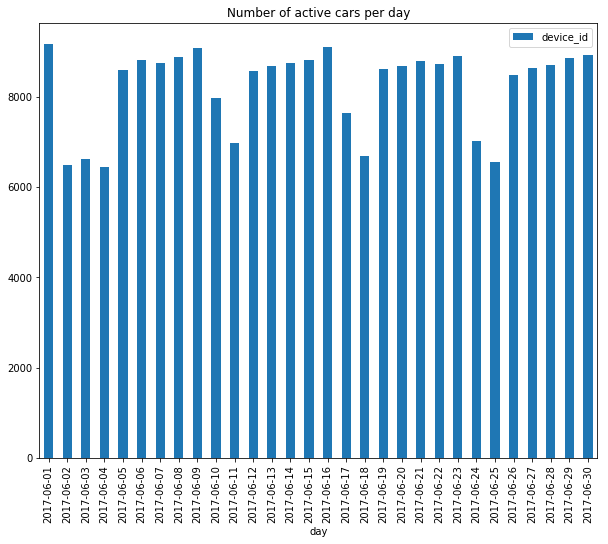

In [20]:
## See how many active cars per day

turin_june[turin_june.engine_status == 1].groupby('day').agg({'device_id': 'nunique'}).plot(kind='bar', 
                                                                                            figsize=(10, 8),
                                                                                           title='Number of active cars per day')

In [162]:
def hour_quarter_range():
    for h in range(24):
        for m in range(0, 60, 15):
            yield "%d:%d" %(h, m) #strtime(h, m)

def avg_speed_dist(data, mode='hour', plotting=True):

    medians = []
    avgs = []

    if mode == 'hour':
        fig = plt.figure(figsize=(20, 30))
        axes = fig.subplots(6, 4)
        for h in range(0, 24, 1):
            i = int(h/4)
            j = h%4
            df = data[data.hour == h].groupby('device_id').agg({'speed': np.mean})
            medians.append(df.speed.quantile(0.5))
            avgs.append(df.speed.mean())
        
            if plotting:
                df.plot(kind='hist', title='Avg speed at %d:00' % h, ax=axes[i, j], bins=15)
    elif mode == 'weekday':
        fig = plt.figure(figsize=(10, 30))
        axes = fig.subplots(4, 2)
        for d in range(1, 8):
            i = int((d-1)/2)
            j = (d-1)%2
            df = data[data.day_of_the_week == d].groupby('device_id').agg({'speed': np.mean})
            medians.append(df.speed.quantile(0.5))
            avgs.append(df.speed.mean())
        
            if plotting:
                df.plot(kind='hist', title='Avg speed at day %d of the week' % d, ax=axes[i, j], bins=15)
                
    elif mode == 'hour_quarter':
        fig = plt.figure(figsize=(10, 30))
        axes = fig.subplots(16, 6)
        for hq in hour_quarter_range():
            print('doing')
            #i = int((d-1)/2)
            #j = (d-1)%2
            df = data[data['hour_&_quarter'] == hq].groupby('device_id').agg({'speed': np.mean})
            medians.append(df.speed.quantile(0.5))
            avgs.append(df.speed.mean())
        
            if plotting:
                df.plot(kind='hist', title='Avg speed at day %d of the week' % d, ax=axes[i, j], bins=15)
            
    if plotting:
        plt.show()
    return medians, avgs

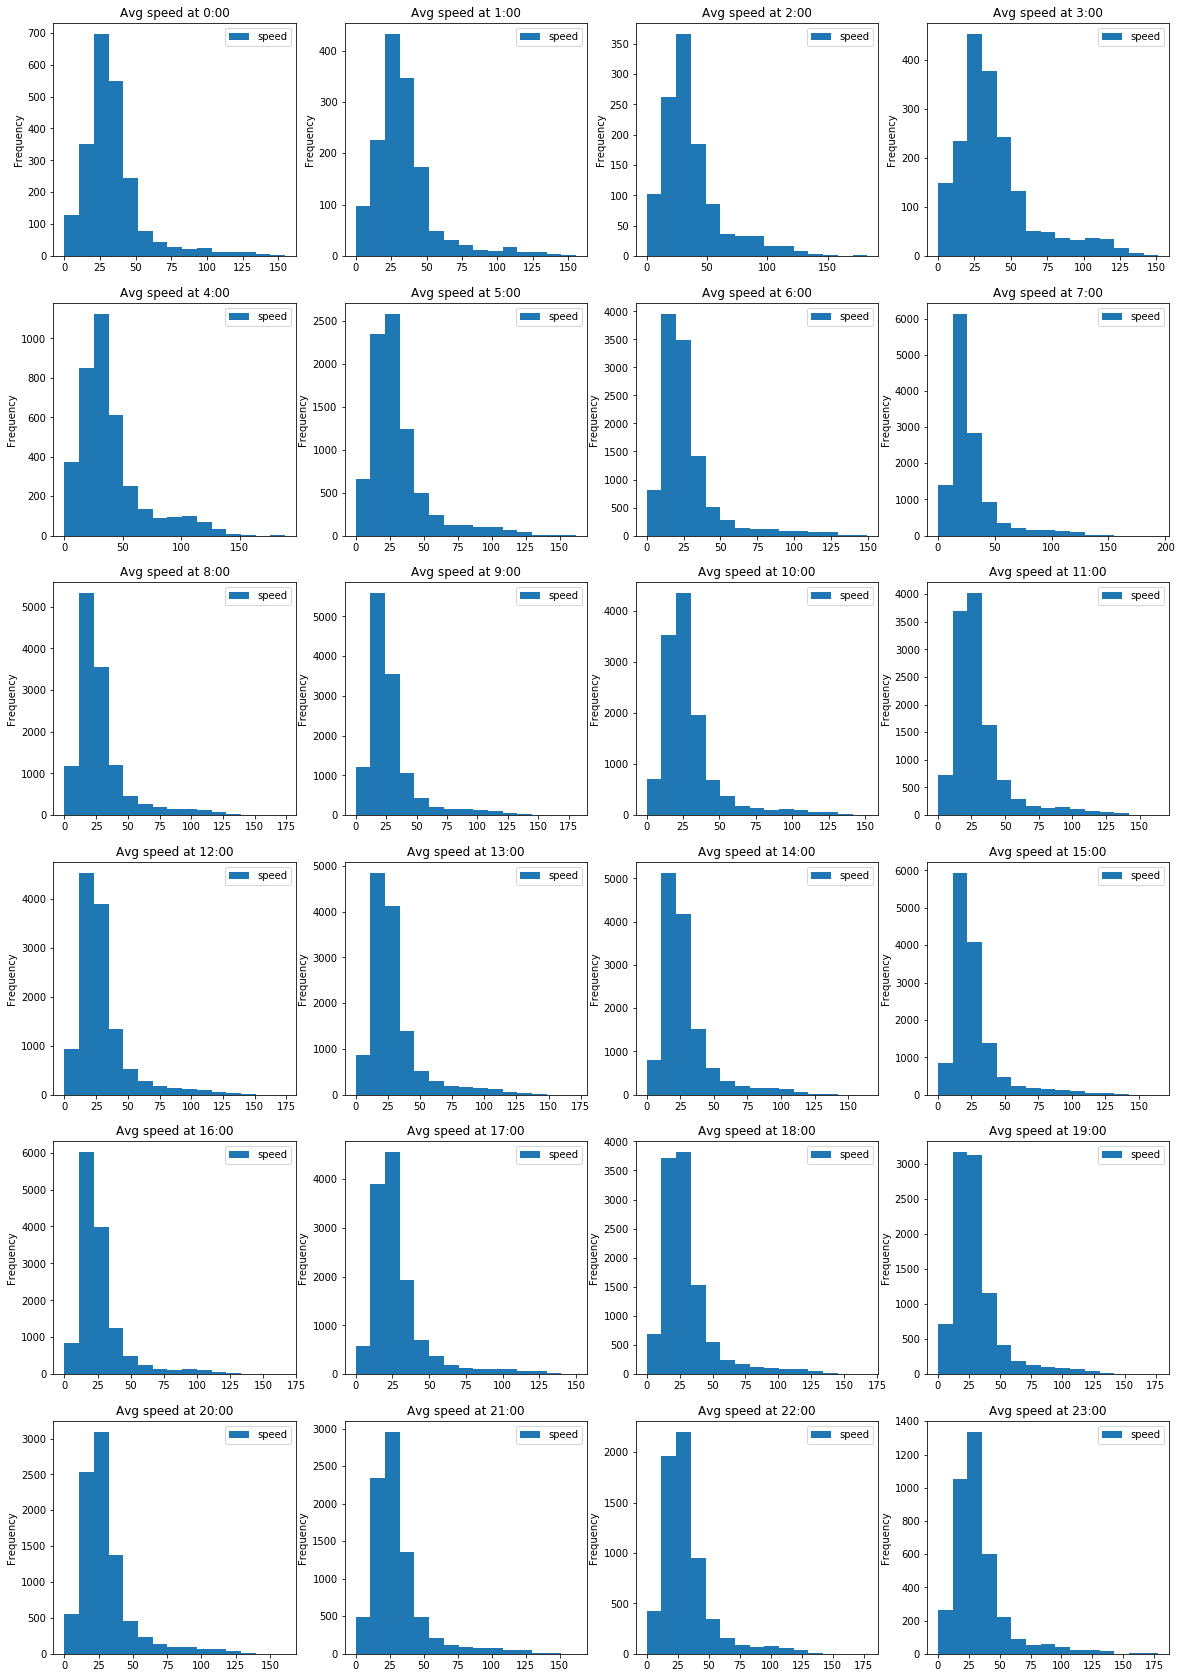

In [113]:
## See average speed by hour of the day, weekends included

medians, avgs = avg_speed_dist(turin_june[turin_june.engine_status == 1])

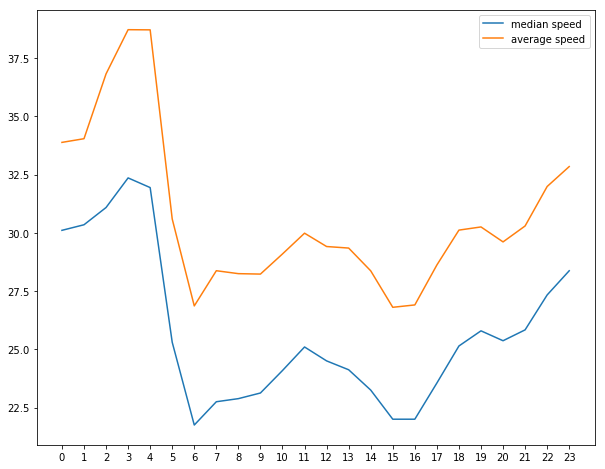

In [115]:
## Plot median and average of speed distribution by hour of the day, weekends included

plt.figure(figsize=(10, 8))
plt.plot(range(0, 24), medians, label='median speed')
plt.plot(range(0, 24), avgs, label='average speed')
plt.xticks(range(0, 24))
plt.legend()

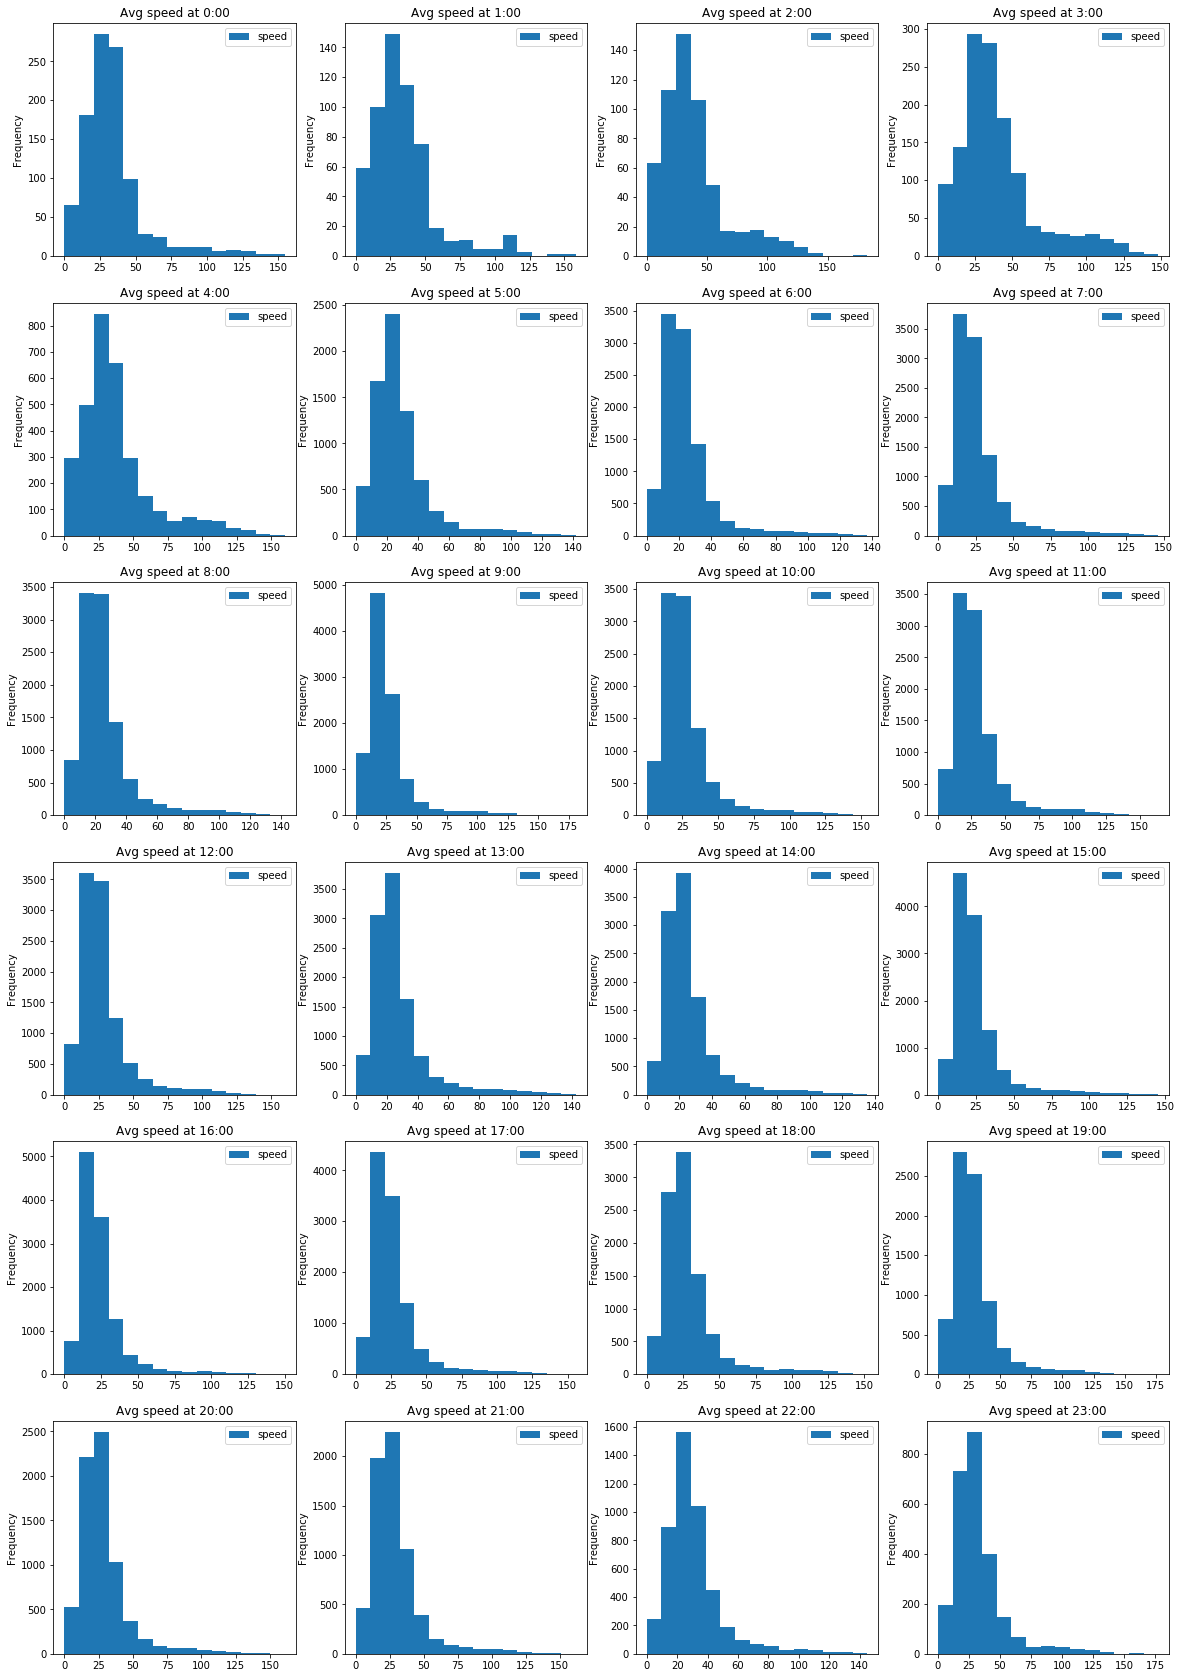

In [91]:
medians2, avgs = avg_speed_dist(turin_june[(turin_june.engine_status == 1) &
                                          (~turin_june.day_of_the_week.isin([6, 7])) &
                                          (turin_june.day != date(2017, 6, 2))])

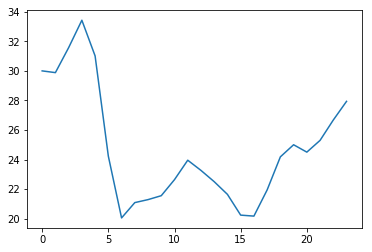

In [92]:
plt.plot(range(0, 24), medians, label='median speed')

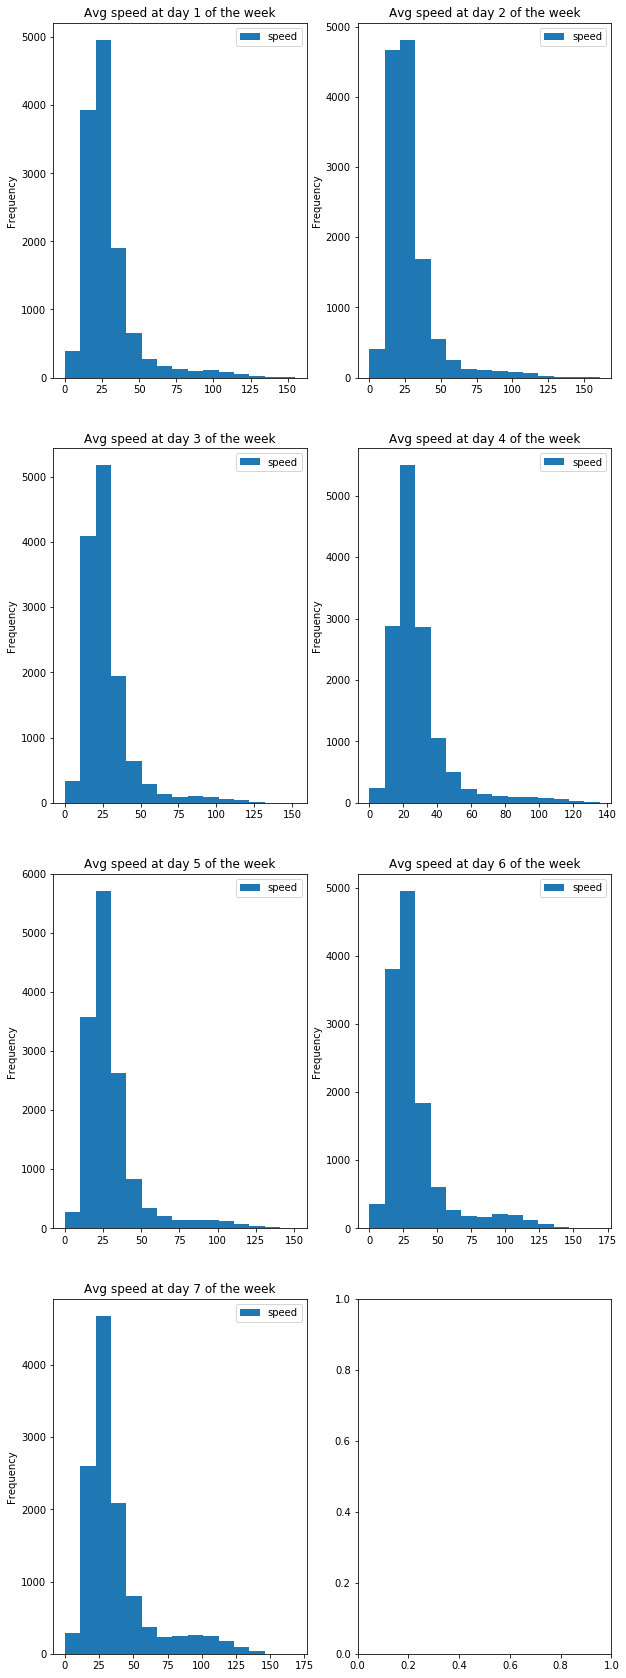

In [107]:
medians_weekday, _ = avg_speed_dist(turin_june[turin_june.engine_status == 1], mode='weekday')

Text(0.5,1,'Median of speed distribution for day of the week')

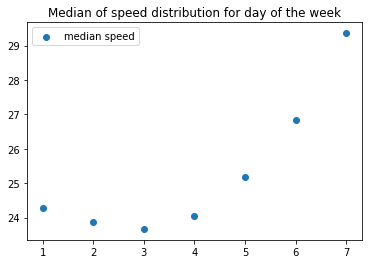

In [112]:
plt.scatter(range(1, 8), medians_weekday, label='median speed')
plt.legend()
plt.title('Median of speed distribution for day of the week')

Text(0.5,1,'Total number of active for day of the week')

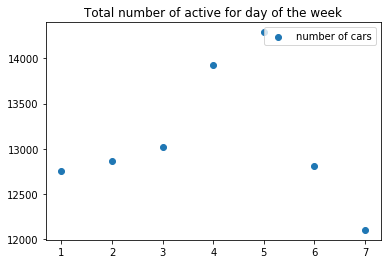

In [225]:
num_of_cars = turin_june[(turin_june.engine_status == 1)].groupby('day_of_the_week').agg({'device_id': 'nunique'}).device_id.tolist()
plt.scatter(range(1, 8), num_of_cars, label='number of cars')
plt.legend()
plt.title('Total number of active cars by day of the week')

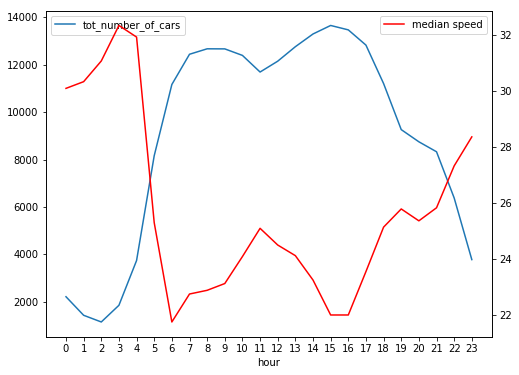

In [130]:
# Number of active cars every HOUR AND median speed 

fig, ax1 = plt.subplots()
turin_june[(turin_june.engine_status == 1)].groupby('hour', as_index=False).agg({'device_id': 
                                                                                 'nunique'})\
.plot(kind='line', x='hour', y='device_id', figsize=(8, 6), label='tot_number_of_cars',
     ax=ax1)
ax1.set_xticks(range(24))
ax2 = ax1.twinx()
ax2.plot(range(0, 24), medians, label='median speed', c='r')
ax1.legend()
ax2.legend()

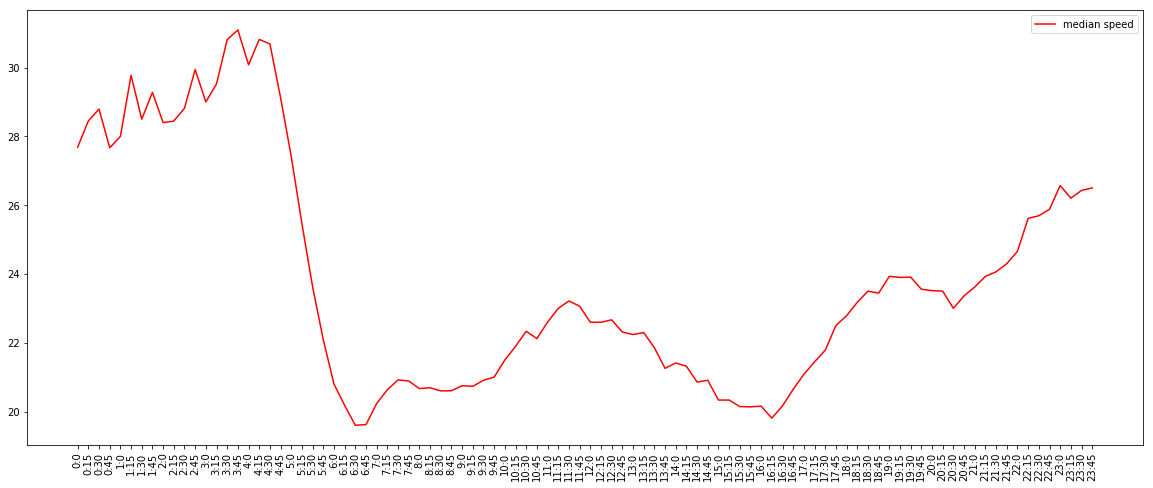

In [206]:
## Look at peaks and bottoms hours for selecting interesting day hours

medians_quarter, _ = avg_speed_dist(turin_june[turin_june.engine_status == 1], mode='hour_quarter', plotting=False)

fig = figure(figsize=(20, 8))
tick = list(hour_quarter_range())
plt.plot(tick, medians_quarter, label='median speed', c='r')
plt.xticks(tick, tick, rotation='vertical')
plt.legend()

Pearson coefficient is -0.949 and its square is 0.900


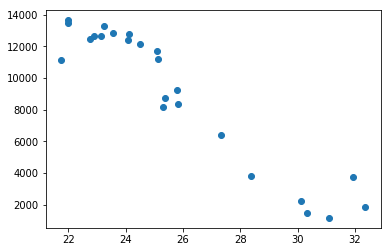

In [136]:
n_cars = turin_june[(turin_june.engine_status == 1)].groupby('hour', as_index=False)\
.agg({'device_id': 'nunique'}).device_id.tolist()

plt.scatter(medians, n_cars)

from scipy.stats import pearsonr

r, _ = pearsonr(medians, n_cars)
print('Pearson coefficient is %.3f and its square is %.3f' % (r, r**2))

In [209]:
## Try DBSCAN on a specific day, namely 2017-06-09 (a friday)

temp = turin_june[(turin_june.engine_status == 1) & (turin_june.day == date(2017, 6, 9)) &
                 (turin_june.recording_date.dt.time.between(time(6, 45), time(6, 46)))]
len(temp), temp.device_id.nunique()

(817, 699)

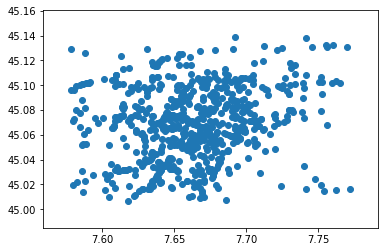

In [213]:
## See how these selected cars are scattered

plt.scatter(coords[:, 0], coords[:, 1])

In [272]:
temp_2 = temp.drop_duplicates(subset='device_id')
coords = temp_2.loc[:, ['lon', 'lat']].values

In [308]:
from sklearn.cluster import DBSCAN
import seaborn as sns
from matplotlib.cm import tab20b

In [316]:
tab20b(cluster_labels).shape

(699, 4)

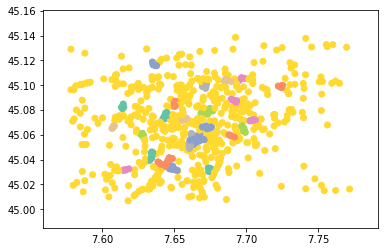

In [321]:
kms_per_radian = 6371.0088
epsilon = 0.3 / kms_per_radian
db = DBSCAN(eps=epsilon, min_samples=5, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))

cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))


pd.DataFrame(coords)
groups = db.fit_predict(np.radians(coords))
plt.scatter(coords[:, 0], coords[:, 1], c=np.array(sns.color_palette('Set2', 30))[groups])

In [291]:
temp_2['label'] = groups
group_speed = temp_2.groupby('labels').agg({'speed': np.mean})[1:]
most_traffic = group_speed[group_speed.speed <= 15].index.values

/Users/stefanocalde/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


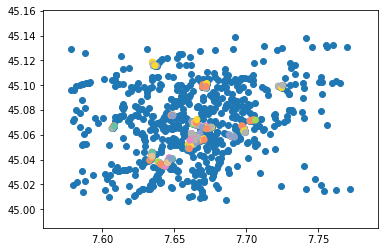

In [318]:
plt.scatter(coords[:, 0], coords[:, 1])
plt.scatter(temp_2[temp_2['label'].isin(most_traffic)].lon.values,
            temp_2[temp_2['label'].isin(most_traffic)].lat.values, c=colors)

In [302]:
colors = np.array(sns.color_palette('Set2', 30))[most_traffic]
len(colors)

15

```python
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])

def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

centermost_points = clusters.map(get_centermost_point)

lats, lons = zip(*centermost_points)
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})

fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(rs['lon'], rs['lat'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
df_scatter = ax.scatter(temp['lon'], temp['lat'], c='k', alpha=0.9, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.show()
```

### Building the first grid

In [28]:
turin_june.loc[:, ['lon', 'lat']].describe().astype(float)

,lon,lat
count,1.649948e+07,1.649948e+07
mean,7.665344e+00,4.507149e+01
std,4.069139e-02,3.090602e-02
min,7.577850e+00,4.500678e+01
25%,7.637361e+00,4.505001e+01
50%,7.663173e+00,4.507142e+01
75%,7.691286e+00,4.509560e+01
max,7.773370e+00,4.514021e+01


In [4]:
def special_floor(n):
    F = floor(n * 100) * 10
    return (F + (((n * 1000) - F)//5) * 5)/1000
    
special_floor(7.697)

7.695

In [5]:
turin_june['grid_lon'] = turin_june.lon.apply(lambda l: special_floor(l))
turin_june['grid_lat'] = turin_june.lat.apply(lambda l: special_floor(l))

In [6]:
turin_june['col_number'] = ((turin_june.grid_lon - turin_june.grid_lon.min()) * 200).round().astype(int)
turin_june['row_number'] = ((turin_june.grid_lat - turin_june.grid_lat.min()) * 200).round().astype(int)

tot_cols = turin_june.col_number.max()
turin_june['cell_number'] = (turin_june.row_number*tot_cols) + turin_june.col_number

In [7]:
agg_speed = turin_june[turin_june.engine_status == 
                       1].groupby(['day_of_the_week', 'hour_half', 
                                   'cell_number']).agg({'speed': np.mean, 'acceleration': np.size,
                                                       'device_id': 'nunique'})\
.rename(columns={'acceleration': 'n_records', 'device_id': 'n_cars'})

In [27]:
distinct_avg_speed = turin_june[turin_june.engine_status == 
                       1].drop_duplicates(subset=['day_of_the_week', 'hour_half', 'cell_number', 
                                                 'device_id']).groupby(['day_of_the_week', 'hour_half', 
                                   'cell_number']).agg({'speed': np.mean, 'device_id': 'nunique'})\
.rename(columns={'device_id': 'n_cars'}).reset_index()

distinct_avg_speed = distinct_avg_speed[distinct_avg_speed.speed > 0]
distinct_avg_speed['TL_c'] = distinct_avg_speed.n_cars / distinct_avg_speed.speed
distinct_tl = distinct_avg_speed.groupby(['day_of_the_week', 
                                   'hour_half'], as_index=False).agg({'TL_c': np.mean})

In [9]:
# Set a threshold to select meaningful rows

agg_speed = agg_speed[agg_speed.n_cars >= 10].reset_index()
tl_c = agg_speed.n_cars / agg_speed.speed
tl_r = agg_speed.n_records / agg_speed.speed
agg_speed['TL_r'] = tl_r
agg_speed['TL_c'] = tl_c

In [19]:
traffic_level = agg_speed.groupby(['day_of_the_week', 
                                   'hour_half'], as_index=False).agg({'TL_r': np.mean, 'TL_c': np.mean})

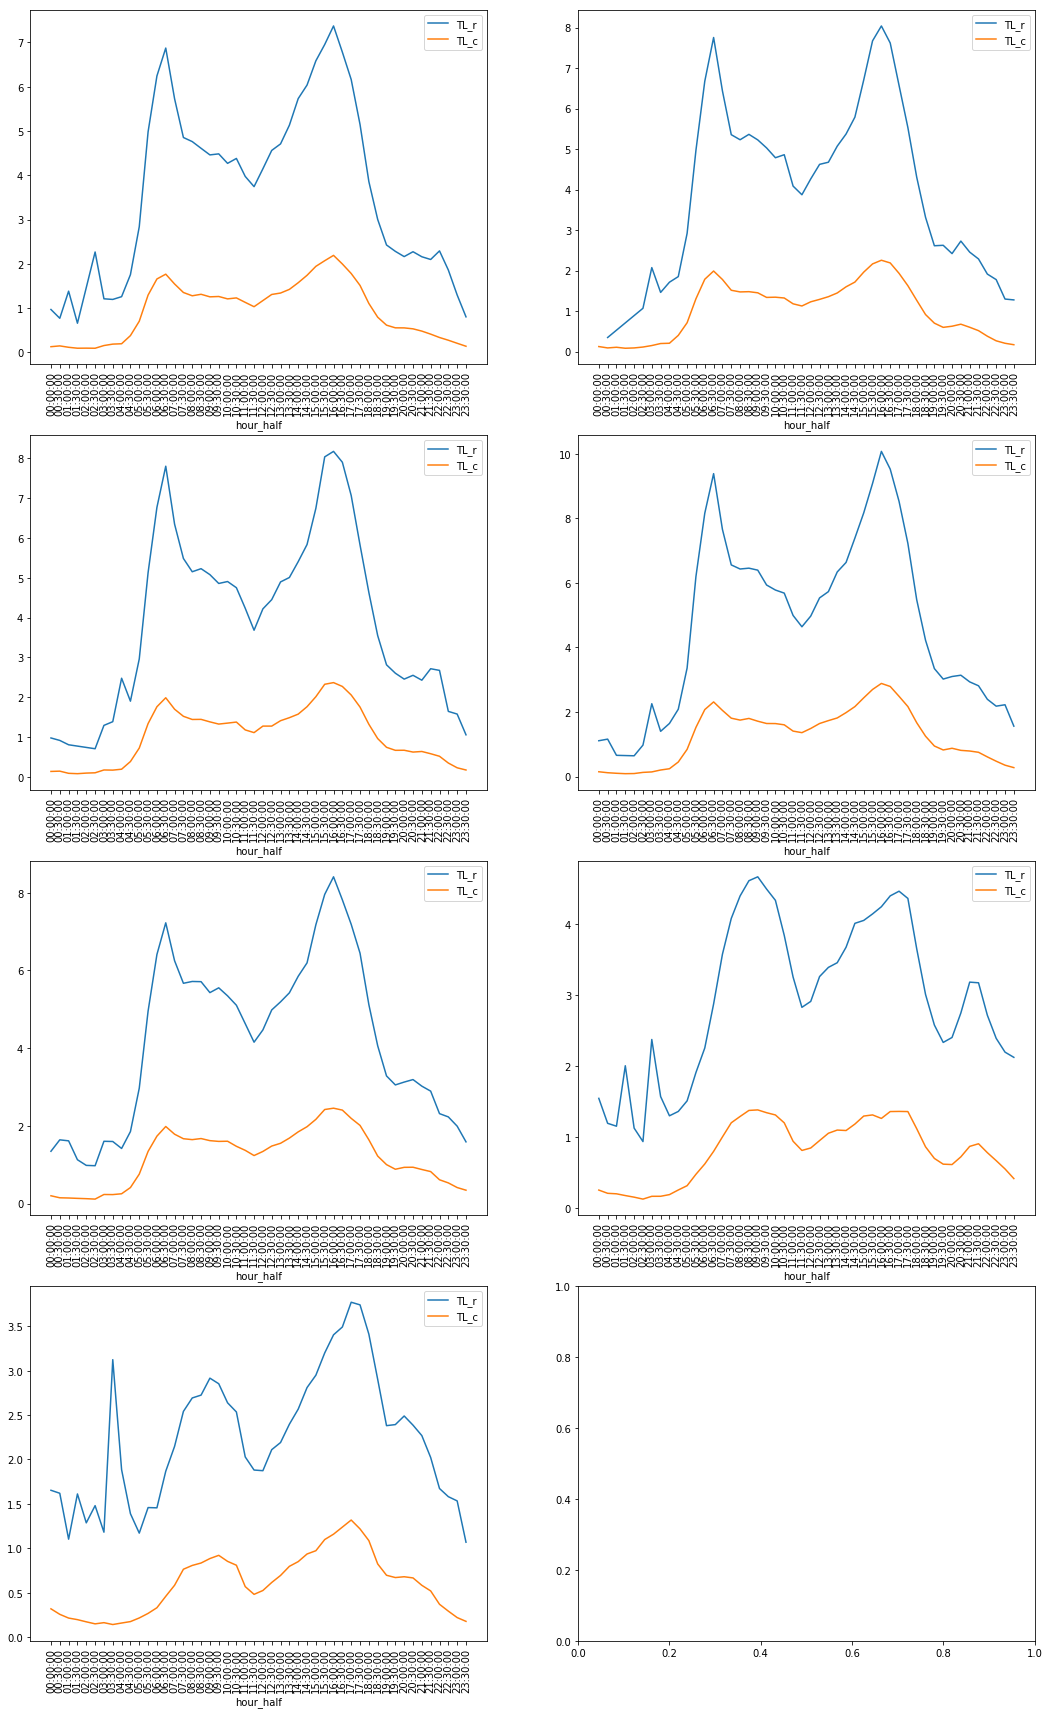

In [39]:
fig = plt.figure(figsize=(18, 30))
hours = sorted(traffic_level.hour_half.unique())
axes = fig.subplots(4, 2)
for d in range(1, 8):
    i = int((d-1)/2)
    j = (d-1)%2
    traffic_level[traffic_level.day_of_the_week == d].plot(x='hour_half', y='TL_r', ax=axes[i,j], label='TL_r', rot=90)
    #traffic_level[traffic_level.day_of_the_week == d].plot(x='hour_half', y='TL_c', ax=axes[i,j], label='TL_c', rot=90)
    distinct_tl[distinct_tl.day_of_the_week == d].plot(x='hour_half', y='TL_c', ax=axes[i, j], label='TL_c', rot=90)
    axes[i, j].set_xticks(hours)
    axes[i, j].legend()

In [42]:
import shapely
#import libHex
import imp 
import folium
import seaborn as sns

name_start_point = "origin_point"
name_end_point = "dest_point"
#7.6017, 45.0080, 7.7336, 45.1326.
max_lon = 7.7336
min_lon = 7.6017
max_lat = 45.1326
min_lat = 45.0080
listpoint =[[max_lat, min_lon], [max_lat, max_lon],[min_lat,max_lon], [min_lat,min_lon], [max_lat,min_lon]]
listpoint = [ [float(x[0]), float(x[1])] for x in listpoint]

circlepoints = []
lat = min_lat
while lat<=max_lat:
    lng = min_lon
    while lng<=max_lon:
        circlepoints.append([lat,lng])
        lng+=(max_lon-min_lon)/10.0
        lat+=(max_lat-min_lat)/10.0
            
lines = []
lat = 45.000
while lat<=45.1401:
    lines.append([[lat,7.575],[lat,7.77]])
    lat+=0.005
    
lon = 7.575
while lon<=7.77:
    lines.append([[45.000,lon],[45.14,lon]])
    lon+=0.005

map_folium =  folium.Map(location = [ (max_lat + min_lat)/2, (max_lon + min_lon)/2], zoom_start=11)

map_folium.add_child(folium.PolyLine(lines,weight=1))

#line = folium.PolyLine(listpoint)
#colors = np.array(sns.color_palette('Set2', 30))[groups].tolist()

#for c, locs in enumerate(circlepoints):
#    folium.CircleMarker(locs,radius=2).add_to(map_folium)
   
#map_folium.add_child(line)
#map_folium.add_child(point)
map_folium

In [82]:
cell_density = turin_june[turin_june.engine_status == 1]\
.groupby(['cell_number', 'day'], as_index=False).agg({'device_id': 'nunique'})\
.groupby('cell_number', as_index=False).agg({'device_id': np.mean})

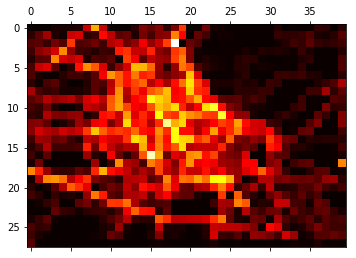

In [87]:
m = np.zeros((28, 40))
for i in range(28):
    for j in range(40):
        cell = i*39 + j
        if len(cell_density.loc[cell_density.cell_number == cell]) == 0:
            m[i, j] = 0
        else:
            m[i, j] = cell_density.loc[cell_density.cell_number == cell, 'device_id'].values[0]
        
plt.matshow(m, cmap='hot')

In [97]:
cell_density[cell_density.device_id < 50].device_id.describe()

count    375.000000
mean      14.853263
std       15.237483
min        1.000000
25%        1.696679
50%        7.700000
75%       27.300000
max       49.566667
Name: device_id, dtype: float64

In [93]:
cell_density.device_id.describe()

count    1070.000000
mean      172.691221
std       180.625760
min         1.000000
25%        23.966667
50%       106.800000
75%       270.558333
max       946.333333
Name: device_id, dtype: float64

In [98]:
## Selecting high density cells only

hd_cells = cell_density[cell_density.device_id >= 50].cell_number.values
ld_cells = cell_density[cell_density.device_id < 50].cell_number.values
len(hd_cells), len(ld_cells)

(695, 375)

In [95]:
distinct_avg_speed = turin_june[(turin_june.engine_status == 1) &
                               turin_june.cell_number.isin(hd_cells)].drop_duplicates(subset=['day_of_the_week', 'hour_half', 'cell_number', 
                                                 'device_id']).groupby(['day_of_the_week', 'hour_half', 
                                   'cell_number']).agg({'speed': np.mean, 'device_id': 'nunique'})\
.rename(columns={'device_id': 'n_cars'}).reset_index()

distinct_avg_speed = distinct_avg_speed[distinct_avg_speed.speed > 0]
distinct_avg_speed['TL_c'] = distinct_avg_speed.n_cars / distinct_avg_speed.speed
distinct_tl = distinct_avg_speed.groupby(['day_of_the_week', 
                                   'hour_half'], as_index=False).agg({'TL_c': np.mean})

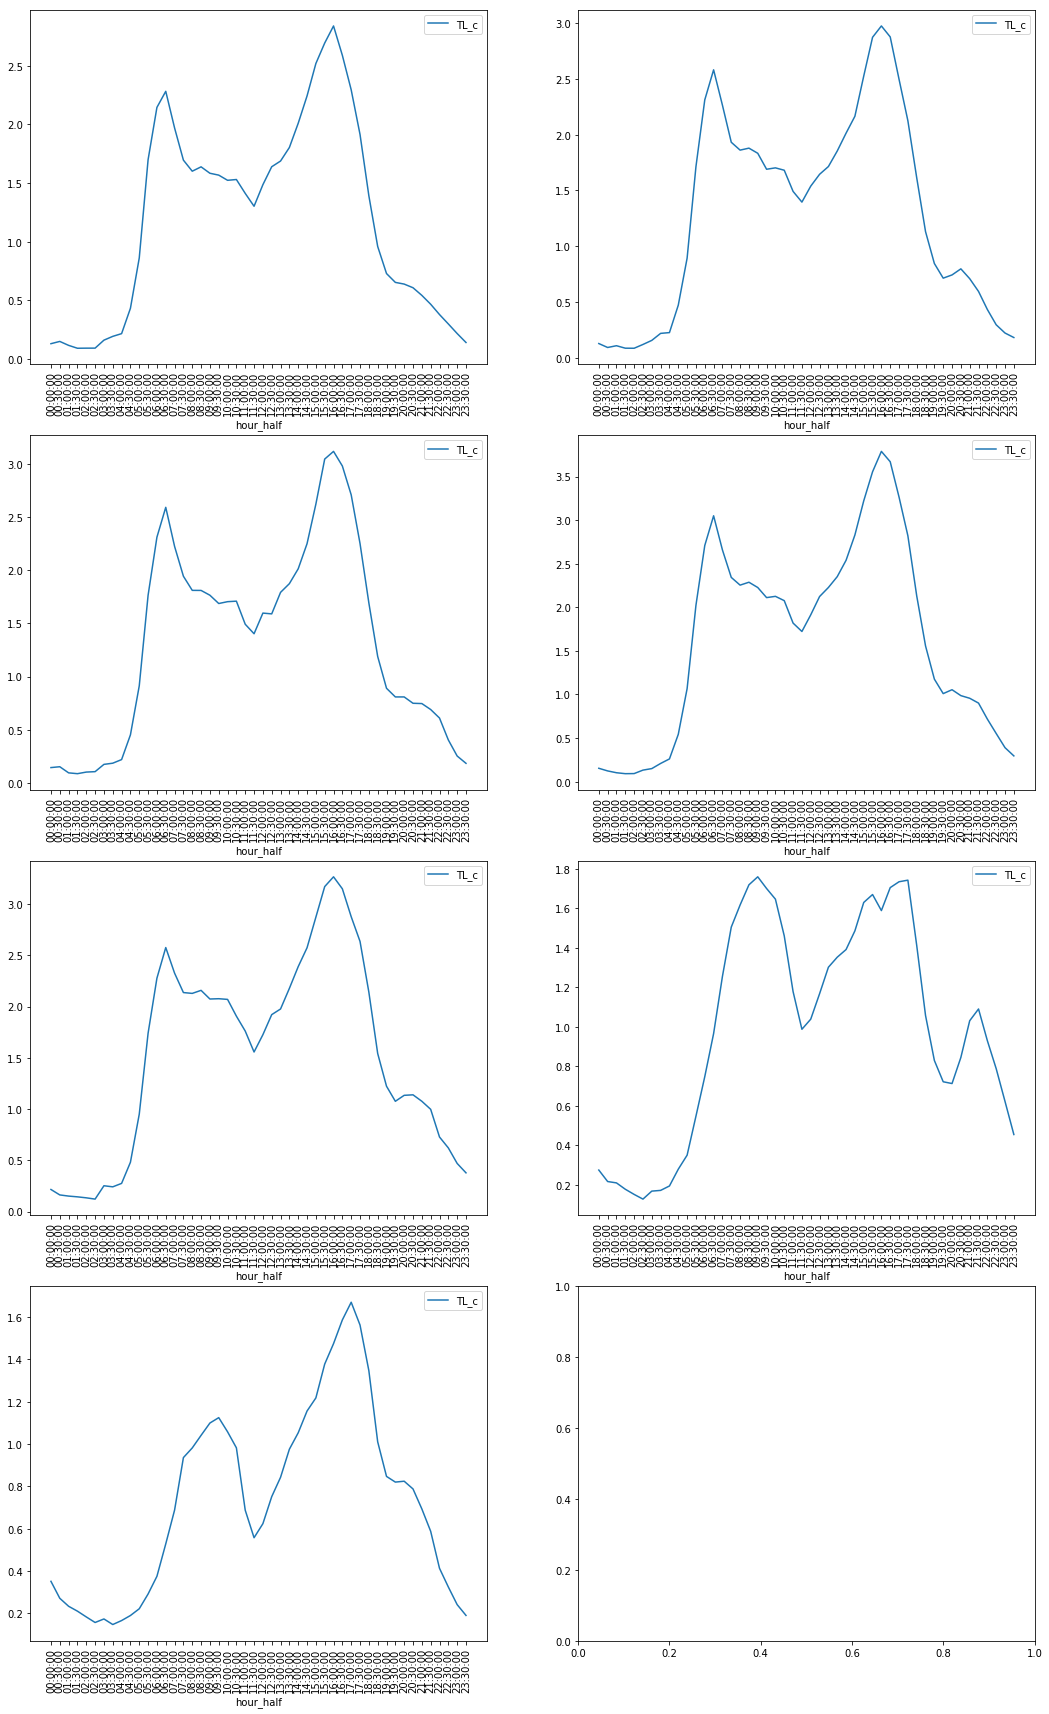

In [96]:
fig = plt.figure(figsize=(18, 30))
hours = sorted(traffic_level.hour_half.unique())
axes = fig.subplots(4, 2)
for d in range(1, 8):
    i = int((d-1)/2)
    j = (d-1)%2
    distinct_tl[distinct_tl.day_of_the_week == d].plot(x='hour_half', y='TL_c', ax=axes[i, j], label='TL_c', rot=90)
    axes[i, j].set_xticks(hours)
    axes[i, j].legend()

### Sum it up

#### What we have learned so far
1. Number of distinct cars / avg speed inside a cell seems a good metric for measuring traffic levels
2. Traffic levels computed in this way seems stable during working days, then have some peculiar shape for saturday and sunday
3. To perform analysis, we chose only the cells with higher density

#### What we can try later
1. Change the grid shape (maybe finer)
2. Change time window
3. Decide aggregation in time window (now we just keep the first value for speed)

#### What we're gonna do now
1. Build the dataset with the feature vector: `weekday`, `hour_half`, `TL_30_min_before`, `TL_left`, `TL_up`, `TL_right`, `TL_down`. If the cell has not 4 neighbours, we set the TL feature values to an average value we compute

In [99]:
## Compute TL avg value for low density cells and insert the weekday-and-hour dependent values in a lookup_table

distinct_avg_speed = turin_june[(turin_june.engine_status == 1) &
                               turin_june.cell_number.isin(ld_cells)].drop_duplicates(subset=['day_of_the_week', 'hour_half', 'cell_number', 
                                                 'device_id']).groupby(['day_of_the_week', 'hour_half', 
                                   'cell_number']).agg({'speed': np.mean, 'device_id': 'nunique'})\
.rename(columns={'device_id': 'n_cars'}).reset_index()

distinct_avg_speed = distinct_avg_speed[distinct_avg_speed.speed > 0]
distinct_avg_speed['TL_c'] = distinct_avg_speed.n_cars / distinct_avg_speed.speed
distinct_tl = distinct_avg_speed.groupby(['day_of_the_week', 
                                   'hour_half'], as_index=False).agg({'TL_c': np.mean})

distinct_tl.describe()

,day_of_the_week,TL_c
count,336.000000,336.000000
mean,4.000000,0.156195
std,2.002983,0.063863
min,1.000000,0.022531
25%,2.000000,0.104884
50%,4.000000,0.161470
75%,6.000000,0.202111
max,7.000000,0.333897


In [101]:
lookup_table = distinct_tl 

In [109]:
## Build the feature vectors

map_h_to_int = dict(zip(hours,range(1, 49)))
map_d_to_int = dict(zip(range(1,8), ['W']*5 + ['ST', 'SN']))
little_turin = turin_june[(turin_june.engine_status == 1) &
                         (turin_june.cell_number.isin(hd_cells))].copy()

# Transform weekday and hour
little_turin['day_of_the_week'] = little_turin.day_of_the_week.map(map_d_to_int)
little_turin['hour_half'] = little_turin.hour_half.map(map_h_to_int)

# Compute tl for each weekday, hour and cell

dataset = little_turin.drop_duplicates(subset=['day_of_the_week', 'hour_half', 'cell_number', 'device_id'])\
.groupby(['day_of_the_week', 'hour_half', 'cell_number'], as_index=False).agg({'device_id': 'nunique', 'speed': np.mean})
dataset.speed.describe()

count    97788.000000
mean        39.665228
std         23.204886
min          0.000000
25%         23.300000
50%         32.333333
75%         48.666667
max        175.000000
Name: speed, dtype: float64

In [118]:
# keep only records with minimum number of cars
dataset = dataset.loc[dataset.device_id >= 9]

dataset['TL'] = dataset.device_id / dataset.speed
dataset.sort_values(by=['cell_number', 'day_of_the_week', 'hour_half'], inplace=True)

In [126]:
def find_neighbours(c):
    return [c - 1, c + 1, c + 39, c - 30]

def previous_hours(h, c, df, day):
    if h == 1:
        if day == 'W':
            prev_h = 48
        elif day == 'ST':
            prev_h == 48
            day == 'W'
        else:
            prev_h == 48
            day == "ST"
    else:
        prev_h = h - 1
    if not len(df[(df.cell_number == c) & (df.hour_half == prev_h) & (df.day_of_the_week == day)]):
        n = find_neighbours(c)
        if not len(df[df.cell_number.isin(n) & (df.hour_half == prev_h) & (df.day_of_the_week == day)]):
            print('Cell %d han no neighs for hour %d!' %(c, h))
            # if
        else:
            return df[df.cell_number.isin(n) & (df.hour_half == prev_h) & (df.day_of_the_week == day)].TL.mean()
    else:
        return df[(df.cell_number == c) & (df.hour_half == prev_h) & (df.day_of_the_week == day)].TL.values[0]

In [128]:
for d in ['W', 'ST', 'SU']:
    for h in range(25, 28):
        for c in little_turin.cell_number.unique():
            print(d, h, c)
            previous_hours(h, c, dataset, d)

W 25 702
W 25 745
W 25 826
W 25 828
W 25 870
W 25 869
W 25 831
W 25 910
W 25 952
W 25 957
W 25 1001
W 25 1043
W 25 1005
W 25 1051
W 25 1052
W 25 1006
W 25 1042
W 25 1000
W 25 956
W 25 954
W 25 909
W 25 827
W 25 865
W 25 864
W 25 784
W 25 744
W 25 743
W 25 197
W 25 44
W 25 8
W 25 48
W 25 88
W 25 89
W 25 128
W 25 129
W 25 91
W 25 130
W 25 131
W 25 132
W 25 94
W 25 96
W 25 135
W 25 174
W 25 252
W 25 213
W 25 134
W 25 168
W 25 83
W 25 785
W 25 787
W 25 829
W 25 866
W 25 832
W 25 833
W 25 872
W 25 830
W 25 742
W 25 911
W 25 955
W 25 1050
W 25 959
W 25 958
W 25 912
W 25 786
W 25 868
W 25 703
W 25 196
W 25 121
W 25 40
W 25 81
W 25 783
W 25 953
W 25 1002
W 25 1047
W 25 1011
W 25 1046
W 25 1044
W 25 746
W 25 704
W 25 871
W 25 867
W 25 159
W 25 960
W 25 924
W 25 885
W 25 845
W 25 846
W 25 807
W 25 808
W 25 770
W 25 731
W 25 730
W 25 691
W 25 651
W 25 612
W 25 611
W 25 610
W 25 571
W 25 533
W 25 532
W 25 492
W 25 491
W 25 452
W 25 412
W 25 451
W 25 450
W 25 449
W 25 487
W 25 486
W 25 485
W 25 524

W 26 93
W 26 51
W 26 9
W 26 45
W 26 122
W 26 202
W 26 203
W 26 204
W 26 244
W 26 283
W 26 322
W 26 361
W 26 400
W 26 439
W 26 478
W 26 556
W 26 438
W 26 243
W 26 162
W 26 133
W 26 118
W 26 119
W 26 160
W 26 161
W 26 200
W 26 120
W 26 78
W 26 79
W 26 41
W 26 80
W 26 7
W 26 15
W 26 54
W 26 172
W 26 251
W 26 291
W 26 329
W 26 292
W 26 331
W 26 371
W 26 410
W 26 413
W 26 453
W 26 405
W 26 366
W 26 367
W 26 330
W 26 290
W 26 211
W 26 207
W 26 206
W 26 245
W 26 246
W 26 208
W 26 209
W 26 171
W 26 55
W 26 56
W 26 95
W 26 16
W 26 19
W 26 58
W 26 18
W 26 797
W 26 759
W 26 720
W 26 721
W 26 682
W 26 648
W 26 609
W 26 796
W 26 688
W 26 727
W 26 767
W 26 729
W 26 728
W 26 689
W 26 649
W 26 757
W 26 650
W 26 681
W 26 520
W 26 480
W 26 719
W 26 717
W 26 755
W 26 753
W 26 792
W 26 793
W 26 794
W 26 795
W 26 680
W 26 756
W 26 835
W 26 607
W 26 568
W 26 570
W 26 606
W 26 494
W 26 454
W 26 414
W 26 372
W 26 333
W 26 332
W 26 254
W 26 214
W 26 253
W 26 293
W 26 294
W 26 295
W 26 334
W 26 373
W 26 374
W 2

W 27 191
W 27 229
W 27 268
W 27 267
W 27 266
W 27 265
W 27 304
W 27 303
W 27 342
W 27 341
W 27 380
W 27 379
W 27 378
W 27 376
W 27 411
W 27 255
W 27 217
W 27 73
W 27 117
W 27 572
W 27 535
W 27 574
W 27 575
W 27 17
W 27 158
W 27 157
W 27 325
W 27 624
W 27 586
W 27 587
W 27 548
W 27 549
W 27 664
W 27 705
W 27 707
W 27 709
W 27 751
W 27 750
W 27 789
W 27 790
W 27 791
W 27 925
W 27 926
W 27 839
W 27 837
W 27 836
W 27 708
W 27 725
W 27 706
W 27 904
W 27 905
W 27 906
W 27 946
W 27 986
W 27 677
W 27 547
W 27 508
W 27 357
W 27 975
W 27 894
W 27 852
W 27 890
W 27 889
W 27 849
W 27 810
W 27 771
W 27 927
W 27 967
W 27 1007
W 27 1053
W 27 1010
W 27 198
W 27 534
W 27 850
W 27 968
W 27 928
W 27 970
W 27 1014
W 27 1013
W 27 974
W 27 1012
W 27 973
W 27 933
W 27 937
W 27 976
W 27 822
W 27 900
W 27 938
W 27 977
W 27 860
W 27 861
W 27 901
W 27 819
W 27 626
W 27 908
W 27 537
W 27 947
W 27 948
W 27 949
W 27 390
W 27 429
W 27 407
W 27 408
W 27 409
W 27 507
W 27 546
W 27 969
W 27 495
W 27 496
W 27 497
W 27 7

ST 25 497
ST 25 772
ST 25 773
ST 25 538
ST 25 536
ST 25 250
ST 25 455
ST 25 195
ST 25 234
ST 25 991
ST 25 634
ST 25 477
ST 25 914
ST 25 875
ST 25 555
ST 25 288
ST 25 324
ST 25 509
ST 25 655
ST 25 510
ST 25 588
ST 25 550
ST 25 590
ST 25 592
ST 25 593
ST 25 591
ST 25 511
ST 25 551
ST 25 512
ST 25 589
ST 25 631
ST 25 961
ST 25 352
ST 25 353
ST 25 354
ST 25 351
ST 25 363
ST 25 891
ST 25 931
ST 25 1045
ST 25 164
ST 25 1038
ST 25 165
ST 25 166
ST 25 553
ST 25 671
ST 25 514
ST 25 851
ST 25 855
ST 25 816
ST 25 778
ST 25 779
ST 25 895
ST 25 853
ST 25 930
ST 25 392
ST 25 391
ST 25 315
ST 25 275
ST 25 673
ST 25 838
ST 25 834
ST 25 240
ST 25 474
ST 25 513
ST 25 313
ST 25 314
ST 25 276
ST 25 239
ST 25 447
ST 25 635
ST 25 573
ST 25 605
ST 25 641
ST 25 498
ST 25 456
ST 25 415
ST 25 176
ST 25 137
ST 25 60
ST 25 61
ST 25 724
ST 25 656
ST 25 697
ST 25 698
ST 25 739
ST 25 777
ST 25 775
ST 25 774
ST 25 613
ST 25 22
ST 25 216
ST 25 1024
ST 25 1025
ST 25 776
ST 25 98
ST 25 800
ST 25 934
ST 25 815
ST 25 935


ST 26 800
ST 26 934
ST 26 815
ST 26 935
Cell 935 han no neighs for hour 26!
ST 26 734
ST 26 814
ST 26 854
ST 26 892
ST 26 416
ST 26 922
ST 26 696
ST 26 738
ST 26 311
ST 26 310
ST 26 377
ST 26 375
ST 26 971
ST 26 499
ST 26 423
Cell 423 han no neighs for hour 26!
ST 26 424
Cell 424 han no neighs for hour 26!
ST 26 385
ST 26 347
Cell 347 han no neighs for hour 26!
ST 26 348
ST 26 115
ST 26 461
ST 26 99
ST 26 817
ST 26 874
ST 26 1039
ST 26 1040
ST 26 71
ST 26 72
Cell 72 han no neighs for hour 26!
ST 26 70
ST 26 473
ST 26 809
ST 26 932
ST 26 112
ST 26 873
ST 27 702
ST 27 745
ST 27 826
ST 27 828
ST 27 870
ST 27 869
ST 27 831
ST 27 910
ST 27 952
ST 27 957
ST 27 1001
ST 27 1043
ST 27 1005
ST 27 1051
ST 27 1052
ST 27 1006
ST 27 1042
ST 27 1000
ST 27 956
ST 27 954
ST 27 909
ST 27 827
ST 27 865
ST 27 864
ST 27 784
ST 27 744
ST 27 743
ST 27 197
ST 27 44
ST 27 8
ST 27 48
ST 27 88
ST 27 89
ST 27 128
ST 27 129
ST 27 91
ST 27 130
ST 27 131
ST 27 132
ST 27 94
ST 27 96
ST 27 135
ST 27 174
ST 27 252
ST 2

Cell 1001 han no neighs for hour 25!
SU 25 1043
Cell 1043 han no neighs for hour 25!
SU 25 1005
Cell 1005 han no neighs for hour 25!
SU 25 1051
Cell 1051 han no neighs for hour 25!
SU 25 1052
Cell 1052 han no neighs for hour 25!
SU 25 1006
Cell 1006 han no neighs for hour 25!
SU 25 1042
Cell 1042 han no neighs for hour 25!
SU 25 1000
Cell 1000 han no neighs for hour 25!
SU 25 956
Cell 956 han no neighs for hour 25!
SU 25 954
Cell 954 han no neighs for hour 25!
SU 25 909
Cell 909 han no neighs for hour 25!
SU 25 827
Cell 827 han no neighs for hour 25!
SU 25 865
Cell 865 han no neighs for hour 25!
SU 25 864
Cell 864 han no neighs for hour 25!
SU 25 784
Cell 784 han no neighs for hour 25!
SU 25 744
Cell 744 han no neighs for hour 25!
SU 25 743
Cell 743 han no neighs for hour 25!
SU 25 197
Cell 197 han no neighs for hour 25!
SU 25 44
Cell 44 han no neighs for hour 25!
SU 25 8
Cell 8 han no neighs for hour 25!
SU 25 48
Cell 48 han no neighs for hour 25!
SU 25 88
Cell 88 han no neighs for ho

Cell 999 han no neighs for hour 25!
SU 25 1003
Cell 1003 han no neighs for hour 25!
SU 25 964
Cell 964 han no neighs for hour 25!
SU 25 598
Cell 598 han no neighs for hour 25!
SU 25 597
Cell 597 han no neighs for hour 25!
SU 25 596
Cell 596 han no neighs for hour 25!
SU 25 595
Cell 595 han no neighs for hour 25!
SU 25 594
Cell 594 han no neighs for hour 25!
SU 25 554
Cell 554 han no neighs for hour 25!
SU 25 515
Cell 515 han no neighs for hour 25!
SU 25 476
Cell 476 han no neighs for hour 25!
SU 25 475
Cell 475 han no neighs for hour 25!
SU 25 516
Cell 516 han no neighs for hour 25!
SU 25 517
Cell 517 han no neighs for hour 25!
SU 25 557
Cell 557 han no neighs for hour 25!
SU 25 883
Cell 883 han no neighs for hour 25!
SU 25 762
Cell 762 han no neighs for hour 25!
SU 25 722
Cell 722 han no neighs for hour 25!
SU 25 683
Cell 683 han no neighs for hour 25!
SU 25 690
Cell 690 han no neighs for hour 25!
SU 25 921
Cell 921 han no neighs for hour 25!
SU 25 1037
Cell 1037 han no neighs for hou

Cell 440 han no neighs for hour 25!
SU 25 441
Cell 441 han no neighs for hour 25!
SU 25 360
Cell 360 han no neighs for hour 25!
SU 25 359
Cell 359 han no neighs for hour 25!
SU 25 36
Cell 36 han no neighs for hour 25!
SU 25 74
Cell 74 han no neighs for hour 25!
SU 25 111
Cell 111 han no neighs for hour 25!
SU 25 370
Cell 370 han no neighs for hour 25!
SU 25 369
Cell 369 han no neighs for hour 25!
SU 25 242
Cell 242 han no neighs for hour 25!
SU 25 281
Cell 281 han no neighs for hour 25!
SU 25 282
Cell 282 han no neighs for hour 25!
SU 25 169
Cell 169 han no neighs for hour 25!
SU 25 170
Cell 170 han no neighs for hour 25!
SU 25 90
Cell 90 han no neighs for hour 25!
SU 25 127
Cell 127 han no neighs for hour 25!
SU 25 126
Cell 126 han no neighs for hour 25!
SU 25 87
Cell 87 han no neighs for hour 25!
SU 25 86
Cell 86 han no neighs for hour 25!
SU 25 85
Cell 85 han no neighs for hour 25!
SU 25 84
Cell 84 han no neighs for hour 25!
SU 25 320
Cell 320 han no neighs for hour 25!
SU 25 358
Ce

Cell 536 han no neighs for hour 25!
SU 25 250
Cell 250 han no neighs for hour 25!
SU 25 455
Cell 455 han no neighs for hour 25!
SU 25 195
Cell 195 han no neighs for hour 25!
SU 25 234
Cell 234 han no neighs for hour 25!
SU 25 991
Cell 991 han no neighs for hour 25!
SU 25 634
Cell 634 han no neighs for hour 25!
SU 25 477
Cell 477 han no neighs for hour 25!
SU 25 914
Cell 914 han no neighs for hour 25!
SU 25 875
Cell 875 han no neighs for hour 25!
SU 25 555
Cell 555 han no neighs for hour 25!
SU 25 288
Cell 288 han no neighs for hour 25!
SU 25 324
Cell 324 han no neighs for hour 25!
SU 25 509
Cell 509 han no neighs for hour 25!
SU 25 655
Cell 655 han no neighs for hour 25!
SU 25 510
Cell 510 han no neighs for hour 25!
SU 25 588
Cell 588 han no neighs for hour 25!
SU 25 550
Cell 550 han no neighs for hour 25!
SU 25 590
Cell 590 han no neighs for hour 25!
SU 25 592
Cell 592 han no neighs for hour 25!
SU 25 593
Cell 593 han no neighs for hour 25!
SU 25 591
Cell 591 han no neighs for hour 25

Cell 742 han no neighs for hour 26!
SU 26 911
Cell 911 han no neighs for hour 26!
SU 26 955
Cell 955 han no neighs for hour 26!
SU 26 1050
Cell 1050 han no neighs for hour 26!
SU 26 959
Cell 959 han no neighs for hour 26!
SU 26 958
Cell 958 han no neighs for hour 26!
SU 26 912
Cell 912 han no neighs for hour 26!
SU 26 786
Cell 786 han no neighs for hour 26!
SU 26 868
Cell 868 han no neighs for hour 26!
SU 26 703
Cell 703 han no neighs for hour 26!
SU 26 196
Cell 196 han no neighs for hour 26!
SU 26 121
Cell 121 han no neighs for hour 26!
SU 26 40
Cell 40 han no neighs for hour 26!
SU 26 81
Cell 81 han no neighs for hour 26!
SU 26 783
Cell 783 han no neighs for hour 26!
SU 26 953
Cell 953 han no neighs for hour 26!
SU 26 1002
Cell 1002 han no neighs for hour 26!
SU 26 1047
Cell 1047 han no neighs for hour 26!
SU 26 1011
Cell 1011 han no neighs for hour 26!
SU 26 1046
Cell 1046 han no neighs for hour 26!
SU 26 1044
Cell 1044 han no neighs for hour 26!
SU 26 746
Cell 746 han no neighs for

Cell 161 han no neighs for hour 26!
SU 26 200
Cell 200 han no neighs for hour 26!
SU 26 120
Cell 120 han no neighs for hour 26!
SU 26 78
Cell 78 han no neighs for hour 26!
SU 26 79
Cell 79 han no neighs for hour 26!
SU 26 41
Cell 41 han no neighs for hour 26!
SU 26 80
Cell 80 han no neighs for hour 26!
SU 26 7
Cell 7 han no neighs for hour 26!
SU 26 15
Cell 15 han no neighs for hour 26!
SU 26 54
Cell 54 han no neighs for hour 26!
SU 26 172
Cell 172 han no neighs for hour 26!
SU 26 251
Cell 251 han no neighs for hour 26!
SU 26 291
Cell 291 han no neighs for hour 26!
SU 26 329
Cell 329 han no neighs for hour 26!
SU 26 292
Cell 292 han no neighs for hour 26!
SU 26 331
Cell 331 han no neighs for hour 26!
SU 26 371
Cell 371 han no neighs for hour 26!
SU 26 410
Cell 410 han no neighs for hour 26!
SU 26 413
Cell 413 han no neighs for hour 26!
SU 26 453
Cell 453 han no neighs for hour 26!
SU 26 405
Cell 405 han no neighs for hour 26!
SU 26 366
Cell 366 han no neighs for hour 26!
SU 26 367
Cell

Cell 616 han no neighs for hour 26!
SU 26 615
Cell 615 han no neighs for hour 26!
SU 26 733
Cell 733 han no neighs for hour 26!
SU 26 694
Cell 694 han no neighs for hour 26!
SU 26 802
Cell 802 han no neighs for hour 26!
SU 26 732
Cell 732 han no neighs for hour 26!
SU 26 654
Cell 654 han no neighs for hour 26!
SU 26 577
Cell 577 han no neighs for hour 26!
SU 26 541
Cell 541 han no neighs for hour 26!
SU 26 503
Cell 503 han no neighs for hour 26!
SU 26 389
Cell 389 han no neighs for hour 26!
SU 26 465
Cell 465 han no neighs for hour 26!
SU 26 693
Cell 693 han no neighs for hour 26!
SU 26 801
Cell 801 han no neighs for hour 26!
SU 26 579
Cell 579 han no neighs for hour 26!
SU 26 466
Cell 466 han no neighs for hour 26!
SU 26 576
Cell 576 han no neighs for hour 26!
SU 26 428
Cell 428 han no neighs for hour 26!
SU 26 350
Cell 350 han no neighs for hour 26!
SU 26 881
Cell 881 han no neighs for hour 26!
SU 26 799
Cell 799 han no neighs for hour 26!
SU 26 617
Cell 617 han no neighs for hour 26

KeyboardInterrupt: 

Text(0.5,1,'Median trip length per day hour')

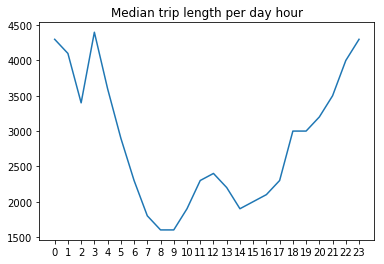

In [25]:
#fig = plt.figure(figsize=(20, 30))
#axes = fig.subplots(6, 4)
median_trip = []
for h in range(24):
    #i = h//4
    #j = h%4
    median_trip.append(turin_june[(turin_june.engine_status == 2) & (turin_june.hour == h)].meters.quantile(0.5))
    #.plot(kind='hist', ax=axes[i, j], #bins=15)
    
plt.plot(range(24), median_trip)
plt.xticks(range(24))
plt.title('Median trip length per day hour')

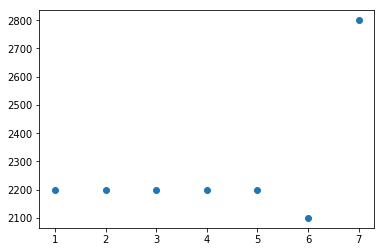

In [22]:
median_day_trip = []
for d in range(1, 8):
    #i = h//4
    #j = h%4
    median_day_trip.append(turin_june[(turin_june.engine_status == 2) &
                                  (turin_june.day_of_the_week == d)].meters.quantile(0.5))
    
plt.scatter(range(1, 8), median_day_trip)

In [ ]:
from recordlinkage

In [ ]:
time_winds = range(10, 35, 5)

In [94]:
WINDOW = time_winds[0]

In [66]:
coords = turin_june[turin_june.engine_status == 1].loc[:, ['lon', 'lat']].values

In [67]:
ti

array([[ 7.579479, 45.099049],
       [ 7.598485, 45.104286],
       [ 7.613513, 45.110054],
       ...,
       [ 7.636   , 45.115135],
       [ 7.636302, 45.115623],
       [ 7.636322, 45.11565 ]])

In [148]:
turin_june['hour_&_quarter'].unique()

array([datetime.time(6, 45), datetime.time(10, 30), datetime.time(10, 45),
       datetime.time(11, 45), datetime.time(12, 0), datetime.time(17, 45),
       datetime.time(18, 0), datetime.time(16, 45), datetime.time(17, 0),
       datetime.time(17, 15), datetime.time(20, 30),
       datetime.time(20, 45), datetime.time(6, 30), datetime.time(19, 0),
       datetime.time(19, 15), datetime.time(7, 0), datetime.time(18, 45),
       datetime.time(15, 30), datetime.time(11, 30),
       datetime.time(19, 30), datetime.time(6, 15), datetime.time(11, 0),
       datetime.time(4, 30), datetime.time(9, 30), datetime.time(9, 45),
       datetime.time(8, 30), datetime.time(16, 15), datetime.time(18, 30),
       datetime.time(12, 15), datetime.time(11, 15),
       datetime.time(18, 15), datetime.time(15, 45),
       datetime.time(17, 30), datetime.time(14, 0), datetime.time(14, 15),
       datetime.time(10, 15), datetime.time(15, 0), datetime.time(15, 15),
       datetime.time(4, 45), datetime.time(5

In [23]:
turin_june

,device_id,recording_date,lat,lon,speed,heading,gps_quality,engine_status,acceleration,meters,day,day_of_the_week,hour,hour_&_quarter
0,3100010,2017-06-01 06:45:38,45.099049,7.579479,103,68,8,1,0,14200,2017-06-01,4,6,06:45:00
1,3100010,2017-06-01 06:46:38,45.104286,7.598485,109,68,8,1,0,15800,2017-06-01,4,6,06:45:00
2,3100010,2017-06-01 06:47:19,45.110054,7.613513,122,56,8,1,0,17200,2017-06-01,4,6,06:45:00
3,3100010,2017-06-01 06:47:23,45.110573,7.614595,123,56,8,1,0,17300,2017-06-01,4,6,06:45:00
4,3100010,2017-06-01 06:47:38,45.113396,7.620533,128,56,8,1,0,17800,2017-06-01,4,6,06:45:00
5,3100010,2017-06-01 06:48:34,45.117565,7.637709,57,176,8,1,3,19400,2017-06-01,4,6,06:45:00
6,3100010,2017-06-01 06:48:38,45.117226,7.637706,16,180,8,1,0,19400,2017-06-01,4,6,06:45:00
7,3100010,2017-06-01 06:48:40,45.117191,7.637701,12,180,8,1,2,19500,2017-06-01,4,6,06:45:00
8,3100010,2017-06-01 06:48:59,45.115688,7.637361,35,266,8,1,3,19600,2017-06-01,4,6,06:45:00
9,3100010,2017-06-01 06:49:38,45.115749,7.635075,0,0,11,1,0,19800,2017-06-01,4,6,06:45:00
